In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

from time import strftime
%matplotlib inline

In [3]:
filedirec = r"D:\Files_Reutlingen_Jenny\main_191021extra"
inputdirectory = r"D:\Files_Reutlingen_Jenny\main_191021extra\191021_extra"
os.chdir(inputdirectory)

In [4]:
filelist = glob.glob('*.h5')
filelist

['aCSF_adult_15min_spont.h5',
 'hCSF_adult_20min_spont0002.h5',
 'hCSF_child_20min_spont.h5']

In [5]:
labeldic = np.load('labeldictionary_MCS_256MEA.npy', allow_pickle='TRUE').item()

In [6]:
filename=filelist[0]


In [7]:
filebase = filename.split('.')[0]

In [8]:
filebase

'aCSF_adult_15min_spont'

In [126]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(inputdirectory, filename))
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [127]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [128]:
timestr = strftime("%d%m%Y")
outputdirectory = os.path.join(filedirec, '_output_Spikesorting_'+ timestr).replace('\\','/')

probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"
outputdirectory_SC='D:/Files_Reutlingen_Jenny/main_191021extra/191021_extra_Spikesorting/output_Spykingcirucs'


In [129]:
outputdirectory

'D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_23042021'

In [130]:
outpath=os.path.join(outputdirectory+'_'+filename.split('.')[0]+'_spikesorting').replace("\\","/")
try:
    os.mkdir(outpath)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting 


In [131]:
outpath_SC=os.path.join(outpath, 'output_spykingcircus').replace("\\","/")
try:
    os.mkdir(outpath_SC)
except OSError:
    print ("Creation of the directory %s failed" % outpath)
else:
    print ("Successfully created the directory %s " % outpath)

Successfully created the directory D:/Files_Reutlingen_Jenny/main_191021extra/_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting 


In [9]:
outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'

In [10]:
os.chdir(outpath)

In [133]:
# cutting out 2 minutes

fs = recording_cmrprobe.get_sampling_frequency()
fs = np.round(fs)
#recording_sub = se.SubRecordingExtractor(recording_cmrprobe, start_frame=200*fs, end_frame=320*fs)

In [134]:
# get the recording length, divide it into 120 second frames
recording_length = recording_cmrprobe.get_num_frames()
recording_seconds = recording_length/fs




In [39]:
def divide_recording_to_sub(recording, sublength_seconds):
    
    
    subrecording_dic = {}
    recording_length = recording.get_num_frames()
    recording_seconds = recording_length/fs
    end_frame = int(recording_seconds)
    
    for snippet in range(0, end_frame, sublength_seconds):
        sub_start = snippet
        sub_end = snippet + sublength_seconds
        if sub_end > end_frame:
            sub_end = end_frame
        sub_str = 'sec_'+str(sub_start)+'-'+str(sub_end)
    
        subrecording_dic[sub_str] = se.SubRecordingExtractor(
            recording_cmrprobe, start_frame = sub_start*fs,
            end_frame = sub_end*fs)
    
    return subrecording_dic
    
    

In [136]:
subrecording_dic

NameError: name 'subrecording_dic' is not defined

In [137]:
#subrecords = divide_recording_to_sub(recording_cmrprobe, 300)

In [13]:
subrecords

NameError: name 'subrecords' is not defined

In [10]:
# make a cache for every part in the dictionary

def create_cache_for_subrecordings(subrecording_dic, filebase, outpath):

    for key in subrecording_dic:
        sub_cache = se.CacheRecordingExtractor(
            subrecording_dic[key])
        filepath = os.path.join(
            outpath, filebase+str(key)+'_filtered_data.dat'
            ).replace('\\','/')
        sub_cache.move_to(filepath) 
        sub_cache.dump_to_dict()
        filepathpickle = os.path.join(
            outpath, filebase+str(key)+'_recording.pkl'
            ).replace('\\','/')
        sub_cache.dump_to_pickle(filepathpickle)
        
    return 'Finished dumping the subrecords. To load, use the load_dumped_recordings function'
    

In [143]:
create_cache_for_subrecordings(subrecording_dic=subrecords, filebase=filebase, outpath=outpath)

'Finished dumping the subrecords. To load, use the load_dumped_recordings function'

In [11]:
def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    

In [12]:
loaded = load_dumped_subrecordings(outpath, filebase)

In [13]:
loaded

{'sec_0-300': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x24d3391a790>,
 'sec_300-600': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x24d3391ac70>,
 'sec_600-900': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x24d3392b700>}

In [148]:
# to load:
#recording_loaded = se.load_extractor_from_pickle('recording.pkl')
#recording_cache=recording_loaded

In [14]:
# loop to run spikesorter over different subrecordings
def run_spykingcircus_on_sub(loaded, directory):
    

    sorted_dic={}
    for key in loaded:
        outpath_SC=os.path.join(outpath, 'sorted_'+str(key)).replace('\\', '/')
        '''
        try:
            os.mkdir(outpath_SC)
        except OSError:
            print ("Creation of the directory %s failed" % outpath)
        else:
            print ("Successfully created the directory %s " % outpath)
        '''
        sorted_dic[key]=ss.run_spykingcircus(
            loaded[key], output_folder=outpath_SC)

    return sorted_dic
    

In [29]:
# run the spikesorting (needs to be unchecked first)
#sorted_dic = run_spykingcircus_on_sub(loaded, outpath)

In [13]:
loaded

{'sec_0-300': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x286fabec8b0>,
 'sec_300-600': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x286fabec670>,
 'sec_600-900': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x286fabf8b80>,
 'sec_900-969': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x286fabecf40>}

In [14]:
sorted_dic

NameError: name 'sorted_dic' is not defined

In [14]:
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic

In [15]:
sorted_dic = load_dumped_sorted_dic(outpath)

In [16]:
sorted_dic


{'sec_0-300': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x24d339329d0>,
 'sec_300-600': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x24d339322e0>,
 'sec_600-900': <spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusSortingExtractor at 0x24d3b61abb0>}

In [18]:
waveforms = st.postprocessing.get_unit_waveforms(
    loaded['sec_0-300'], sorted_dic['sec_0-300'], memmap = True
    )

In [17]:
u = 'sec_0-300'

In [17]:
layerdic = {'layer1':[], 
            'layer2-3':['L1', 'M1', 'M2', 'M3', 'M15', 'M16', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                        'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O1', 'O2', 'O3', 'O4', 
                        'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'P1', 
                        'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 
                        'P15', 'P16', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 
                        'R13', 'R14', 'R15'],
           'layer4':['K1', 'K2', 'K14', 'K15', 'K16', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 
                     'L13', 'L14', 'L15', 'L16', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14'],
           'layer5-6':['K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'I1', 'I2', 'I3', 'I4', 
                       'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'H1', 'H2', 'H3', 
                       'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 
                      'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16',
                       'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
                       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
           'whitematter':['D12', 'D13', 'D14', 'D15', 'D16', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 
                          'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                          'A10', 'A11', 'A12', 'A13', 'A14', 'A15' ]}

In [18]:
# loop to invert
layerdic_invert = {}

for key in layerdic:
    for i in layerdic[key]:
        layerdic_invert[i]=key

In [19]:
labeldic_invert = {}

for key in labeldic:
    keystring = str(labeldic[key])
    labeldic_invert[keystring] = key

In [24]:
#load
#sorting_SC = se.SpykingCircusSortingExtractor(outpath_SC)


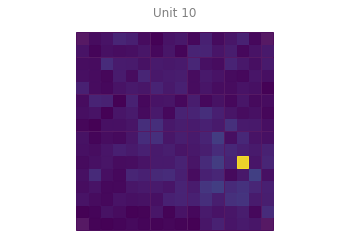

In [20]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[10])

{}


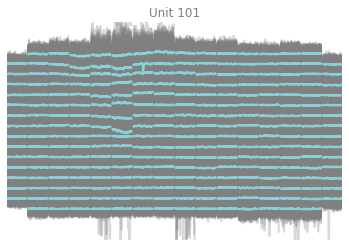

In [23]:
w_wf = sw.plot_unit_waveforms(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[101], color='#89D1D9')

<IPython.core.display.Javascript object>


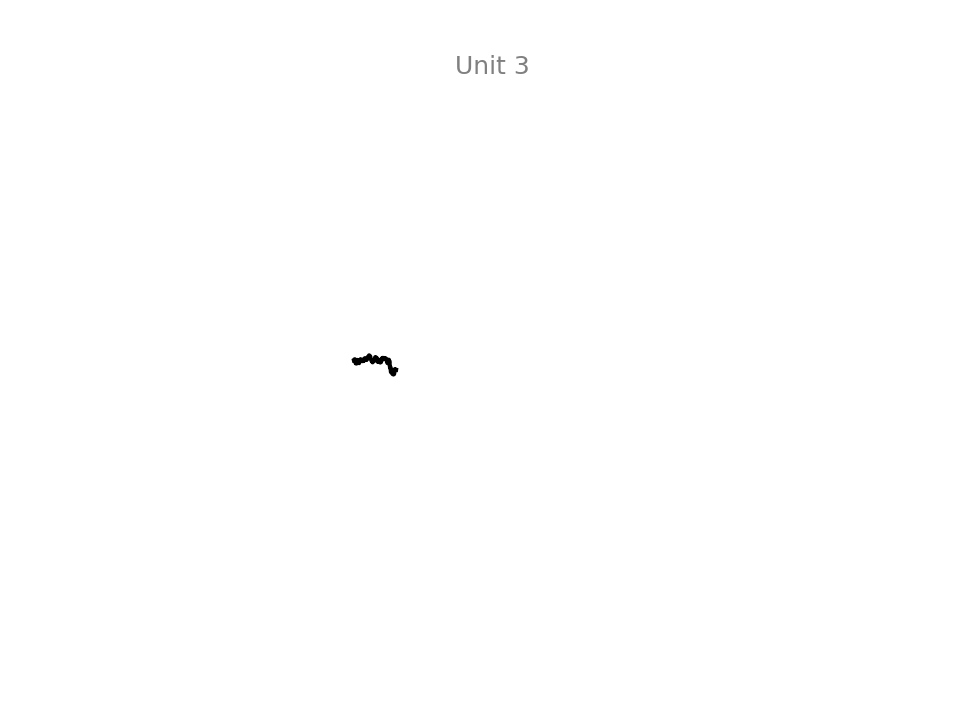

{}


In [132]:
sw.plot_unit_templates(loaded['sec_0-300'],  sorted_dic['sec_0-300'], unit_ids=[3], max_channels=1, )

In [1]:
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
    
#     features = st.postprocessing.compute_unit_template_features(
#         recording_cache[dictkey], 
#         sorted_dic[dictkey], 
#         as_dataframe=True
#         )
    
#     quality_metrics = st.validation.compute_quality_metrics(
#         sorted_dic[dictkey], 
#         recording_cache[dictkey], 
#         metric_names=['firing_rate', 'isi_violation', 'snr', 
#                       'amplitude_cutoff', 'presence_ratio'],
#         as_dataframe=True
#         )
    
    
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
        # add features
#         unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_to_valley']=features.loc[i]['peak_to_valley']
#         unitframe.loc[(unitframe['unit_ids']==i), 'ft_halfwidth']=features.loc[i]['halfwidth']
#         unitframe.loc[(unitframe['unit_ids']==i), 'ft_peak_trough_ratio']=features.loc[i]['peak_trough_ratio']
#         unitframe.loc[(unitframe['unit_ids']==i), 'ft_repolarization_slope']=features.loc[i]['repolarization_slope']
#         unitframe.loc[(unitframe['unit_ids']==i), 'ft_recovery_slope']=features.loc[i]['recovery_slope']

        # add quality metrics
#         unitframe.loc[(unitframe['unit_ids']==i), 'qm_firing_rate']=quality_metrics.loc[i]['firing_rate']
#         unitframe.loc[(unitframe['unit_ids']==i), 'qm_isi_violation']=quality_metrics.loc[i]['isi_violation']
#         unitframe.loc[(unitframe['unit_ids']==i), 'qm_amplitude_cutoff']=quality_metrics.loc[i]['amplitude_cutoff']
#         unitframe.loc[(unitframe['unit_ids']==i), 'qm_presence_ratio']=quality_metrics.loc[i]['presence_ratio']
#         unitframe.loc[(unitframe['unit_ids']==i), 'qm_snr']=quality_metrics.loc[i]['snr']
        
        
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
    return unitframe

In [109]:
unitframe2 = units_to_pandas_DataFrame(
    sorted_dic = sorted_dic,
    recording_cache = loaded,
    dictkey='sec_300-600',
    layerdic_invert=layerdic_invert,
    recordingdate = '21.10.2019'
    )

In [110]:
unitframe2

,unit_ids,max_channel,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
0,0,0.0,R12,77.0,0.256667,layer2-3,aCSF_adult_15min_spont,sec_300-600,21.10.2019
1,1,20.0,H1,37.0,0.123333,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
2,10,40.0,K7,1055.0,3.516667,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
3,100,81.0,P1,943.0,3.143333,layer2-3,aCSF_adult_15min_spont,sec_300-600,21.10.2019
4,101,91.0,G2,3244.0,10.813333,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
...,...,...,...,...,...,...,...,...,...
829,95,51.0,I1,510.0,1.700000,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
830,96,51.0,I1,394.0,1.313333,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
831,97,51.0,I1,30.0,0.100000,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019
832,98,61.0,I14,1512.0,5.040000,layer5-6,aCSF_adult_15min_spont,sec_300-600,21.10.2019


In [111]:
dictkey = unitframe2['subrecording'][0]
dictkey

'sec_300-600'

In [112]:
dictkey = unitframe2['subrecording'][0]
unitframe2.to_pickle(str('DF_' + filebase + '_' + dictkey) + '_df.pkl')

In [102]:
os.chdir(outpath)

In [103]:
loaded

{'sec_0-300': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x29f253e28e0>,
 'sec_300-600': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x29f263184f0>,
 'sec_600-900': <spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor at 0x29f26318af0>}

In [21]:
framefiles = glob.glob('*df.pkl')
framefiles

['DF_aCSF_adult_15min_spont_complete_df.pkl',
 'DF_aCSF_adult_15min_spont_sec_0-300_df.pkl',
 'DF_aCSF_adult_15min_spont_sec_300-600_df.pkl',
 'DF_aCSF_adult_15min_spont_sec_600-900_df.pkl']

In [114]:
df0 = pd.read_pickle(framefiles[0])
df1 = pd.read_pickle(framefiles[1])
df2 = pd.read_pickle(framefiles[2])

In [42]:
df0

,unit_ids,max_channel,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
0,0,0.0,R12,449.0,1.496667,layer2-3,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
1,1,0.0,R12,58.0,0.193333,layer2-3,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
2,10,20.0,H1,323.0,1.076667,layer5-6,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
3,100,242.0,E14,581.0,1.936667,layer5-6,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
4,101,242.0,E14,1258.0,4.193333,layer5-6,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
...,...,...,...,...,...,...,...,...,...
961,964,241.0,B13,955.0,3.183333,whitematter,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
962,965,251.0,L15,1335.0,4.450000,layer4,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
963,97,232.0,B9,440.0,1.466667,whitematter,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019
964,98,242.0,E14,409.0,1.363333,layer5-6,hCSF_adult_20min_spont0002,sec_0-300,21.10.2019


In [115]:
completeframe = df0.append([df1, df2])

In [48]:
completeframe[2000:2100]

,unit_ids,max_channel,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
190,27,70.0,P9,1779.0,5.930000,layer2-3,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
191,270,244.0,G11,237.0,0.790000,layer5-6,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
192,271,244.0,G11,179.0,0.596667,layer5-6,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
193,272,3.0,P11,573.0,1.910000,layer2-3,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
194,273,13.0,M5,1386.0,4.620000,layer4,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
...,...,...,...,...,...,...,...,...,...
285,355,245.0,M14,606.0,2.020000,layer4,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
286,356,154.0,G7,51.0,0.170000,layer5-6,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
287,357,4.0,L9,3026.0,10.086667,layer4,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019
288,358,4.0,L9,1168.0,3.893333,layer4,hCSF_adult_20min_spont0002,sec_600-900,21.10.2019


In [116]:
completeframe.to_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [22]:
completeframe = pd.read_pickle(framefiles[0])

In [55]:
features

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.00104,0.00024,-0.252763,0.008233,-0.002739
1,0.00116,0.00028,-0.197648,0.021199,-0.002510
10,0.00096,0.00028,-0.196599,0.026173,-0.001884
100,0.00068,0.00020,-0.185871,0.039990,0.000065
101,0.00104,0.00052,-0.427789,0.023000,-0.005009
...,...,...,...,...,...
95,0.00040,0.00024,-0.387625,0.053166,-0.006133
96,0.00124,0.00036,-0.342497,0.014307,-0.005272
97,0.00060,0.00028,-0.352343,0.055141,-0.007553
98,0.00076,0.00028,-0.250553,0.045662,-0.004389


In [73]:
features = st.postprocessing.compute_unit_template_features(
        loaded['sec_300-600'], 
        sorted_dic['sec_300-600'], 
        as_dataframe=True, 
        unit_ids = list_not_empty_spiketrains
        )

ValueError: cannot mmap an empty file

In [52]:
quality_metrics = st.validation.compute_quality_metrics(
    sorted_dic['sec_0-300'], 
    loaded['sec_0-300'], 
    metric_names=['firing_rate', 'isi_violation', 'snr', 
                  'amplitude_cutoff', 'presence_ratio'],
    as_dataframe=True,
    unit_ids=list_not_empty_spiketrains
    )



In [53]:
quality_metrics

,firing_rate,presence_ratio,isi_violation,amplitude_cutoff,snr
0,6.106667,1.00,0.332178,0.018512,2.225835
1,1.996667,0.99,0.564945,0.019730,2.815771
10,0.063333,0.18,0.000000,0.013620,4.191528
100,12.420000,1.00,2.445618,0.148154,3.064167
101,4.276667,1.00,4.186828,0.042039,3.594331
...,...,...,...,...,...
95,5.643333,1.00,0.742566,0.000863,3.144036
96,1.876667,0.99,0.319752,0.000863,2.693342
97,4.060000,1.00,0.409908,0.107820,3.447417
98,3.166667,1.00,0.112301,0.124997,4.220980


In [72]:
list_not_empty_spiketrains = []

ids = sorted_dic['sec_300-600'].get_unit_ids()
for i in ids:
    st_len = len(sorted_dic['sec_0-300'].get_unit_spike_train(unit_id=i))
    if st_len > 0:
        list_not_empty_spiketrains.append(i)

In [73]:
len(ids)

966

In [46]:
sorted_dic[u]

In [47]:
features = st.postprocessing.compute_unit_template_features(
    loaded[u], 
    sorted_dic[u], 
    as_dataframe=True
    )


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [37]:
features

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.00132,0.00032,-0.308642,0.032623,-0.003106
1,0.00112,0.00028,-0.366667,0.017728,-0.002502
10,0.00120,0.00028,0.116998,NaN,-0.000533
100,0.00108,0.00044,-0.258162,0.169479,-0.023654
101,0.00080,0.00036,-0.324324,0.147332,-0.014374
...,...,...,...,...,...
95,0.00044,0.00024,-0.263305,0.086346,-0.009415
96,0.00188,0.00044,0.037855,NaN,-0.009115
97,0.00184,0.00048,0.013889,NaN,-0.009115
98,0.00064,0.00036,0.107639,NaN,-0.001133


In [33]:
u = 'sec_300-600'

# Waveforms and Template Plots

In [34]:
# calculate waveforms 
wf = st.postprocessing.get_unit_waveforms(loaded[u], sorted_dic[u], ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

Number of chunks: 31 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##################################################| 31/31 [08:17<00:00, 16.05s/it]


In [48]:
print(sorted_dic[u].get_shared_unit_spike_feature_names())
print(wf[0].shape)

['amplitudes', 'amplitudes_idxs', 'waveforms', 'waveforms_idxs']
(52, 252, 148)


In [49]:
#fig, ax = plt.subplots()
#ax.plot(wf[0][:, 0, :].T, color='k', lw=0.3)

In [76]:
templates = st.postprocessing.get_unit_templates(loaded[u], sorted_dic[u], max_spikes_per_unit=200, 
                                                 save_as_property=True, verbose=True)

In [51]:
unitframe.loc[2]

unit_ids                                       10
max_channel                                    30
channellabel                                  O11
n_spikes                                      281
firing_rate                              0.936667
layer                                    layer2-3
ft_peak_to_valley                         0.00084
ft_halfwidth                              0.00032
ft_peak_trough_ratio                    -0.179012
ft_repolarization_slope                  0.042495
ft_recovery_slope                      -0.0048764
qm_firing_rate                           0.936667
qm_isi_violation                          11.5521
qm_amplitude_cutoff                   0.000920956
qm_presence_ratio                            0.88
qm_snr                                    4.33931
file                       aCSF_adult_15min_spont
Name: 2, dtype: object

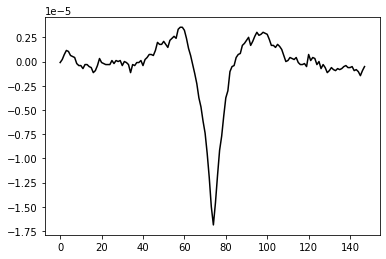

In [52]:
fig, ax = plt.subplots()
ax.plot(templates[2][30].T, color='k')


In [49]:
labeldic[40]

'K7'

idee: templates pro channel darstellen -> also den dataframe nach channel sortieren, dich mit key: channel, value: units

In [50]:
unitlist_by_index = list(unitframe.loc[(unitframe['max_channel'])==0].index)

In [51]:
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==1]['unit_ids'])

In [52]:
unitlist_by_channel

[80, 81, 82]

In [82]:
j = 0 #entsprich dem maxchannel
#j=labeldic_invert['F8'] 
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
print(unitlist_by_index)
unitframe.loc[unitlist_by_index[0]]['channellabel']

Int64Index([0], dtype='int64')


'R12'

In [83]:
labeldic_invert[unitframe.loc[unitlist_by_index[0]]['channellabel']]

0

In [84]:
unitlist_by_index

Int64Index([0], dtype='int64')

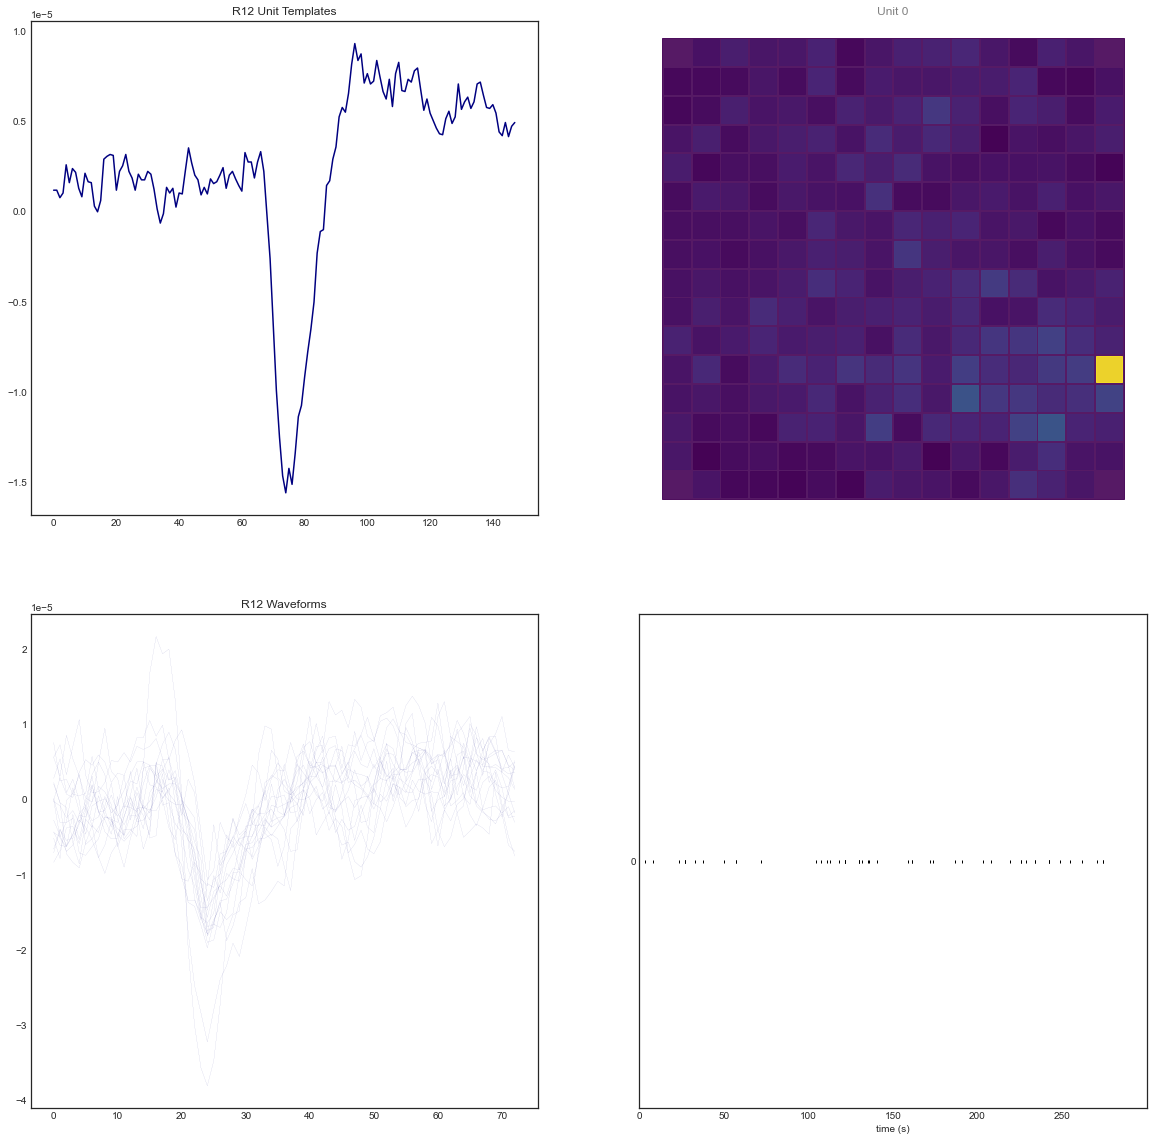

In [87]:
#colourlist = ['#D7D7D9', '#162473', '#449CA6', '#038C73', '#BF4417', '#7EBF88', '#D0F2D3', '#F2CB57']
n = len(unitlist_by_index)
colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))

plt.style.use("seaborn-white")

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
      
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[(unitlist_by_channel[0])], ax=ax2)



#ax3.plot(loaded['sec_0-300'].get_traces()[j])

#sw.plot_timeseries(loaded['sec_0-300'], trange=[5, 8], ax=ax3,)

#sw.plot_activity_map(loaded['sec_0-300'], ax=ax3)

for i in unitlist_by_index:
    colourcode = color=next(colors)
    ax1.plot(templates[i][j].T, color=colourcode)
    ax1.set_title(str(unitframe.loc[i]['channellabel']) + ' Unit Templates')

    ax3.plot(wf[i][:, j, :].T, color=colourcode, lw=0.05)
    ax3.set_title(str(unitframe.loc[i]['channellabel']) + ' Waveforms')
    
sw.plot_crosscorrelograms(sorted_dic['sec_0-300'], unit_ids=unitlist_by_index, ax=ax4, bin_size=1, window=10)
    
    
#sw.plot_rasters(sorted_dic[u], color='k', unit_ids=unitlist_by_channel, ax = ax4)

#sw.plot_pca_features(sorting=sorted_dic[u], recording = loaded[u], unit_ids=unitlist_by_channel, ax=ax6)



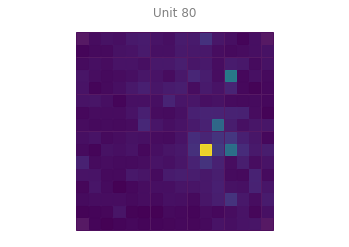

In [336]:
sw.plot_unit_template_maps(loaded['sec_0-300'],  sorted_dic['sec_0-300'], max_spikes_per_unit=100, unit_ids=[80], figure=)

R12
Int64Index([0, 1], dtype='int64')
O11
Int64Index([2, 13, 430, 725, 736], dtype='int64')
F8
Int64Index([  3,   8,  41,  72,  74,  75,  76,  80,  96,  97,  98,  99, 100,
            107, 171, 207, 223, 340, 512, 531, 532, 549, 603, 682],
           dtype='int64')
G2
Int64Index([4, 5, 6, 7, 746], dtype='int64')
P10
Int64Index([9, 10, 11, 12], dtype='int64')


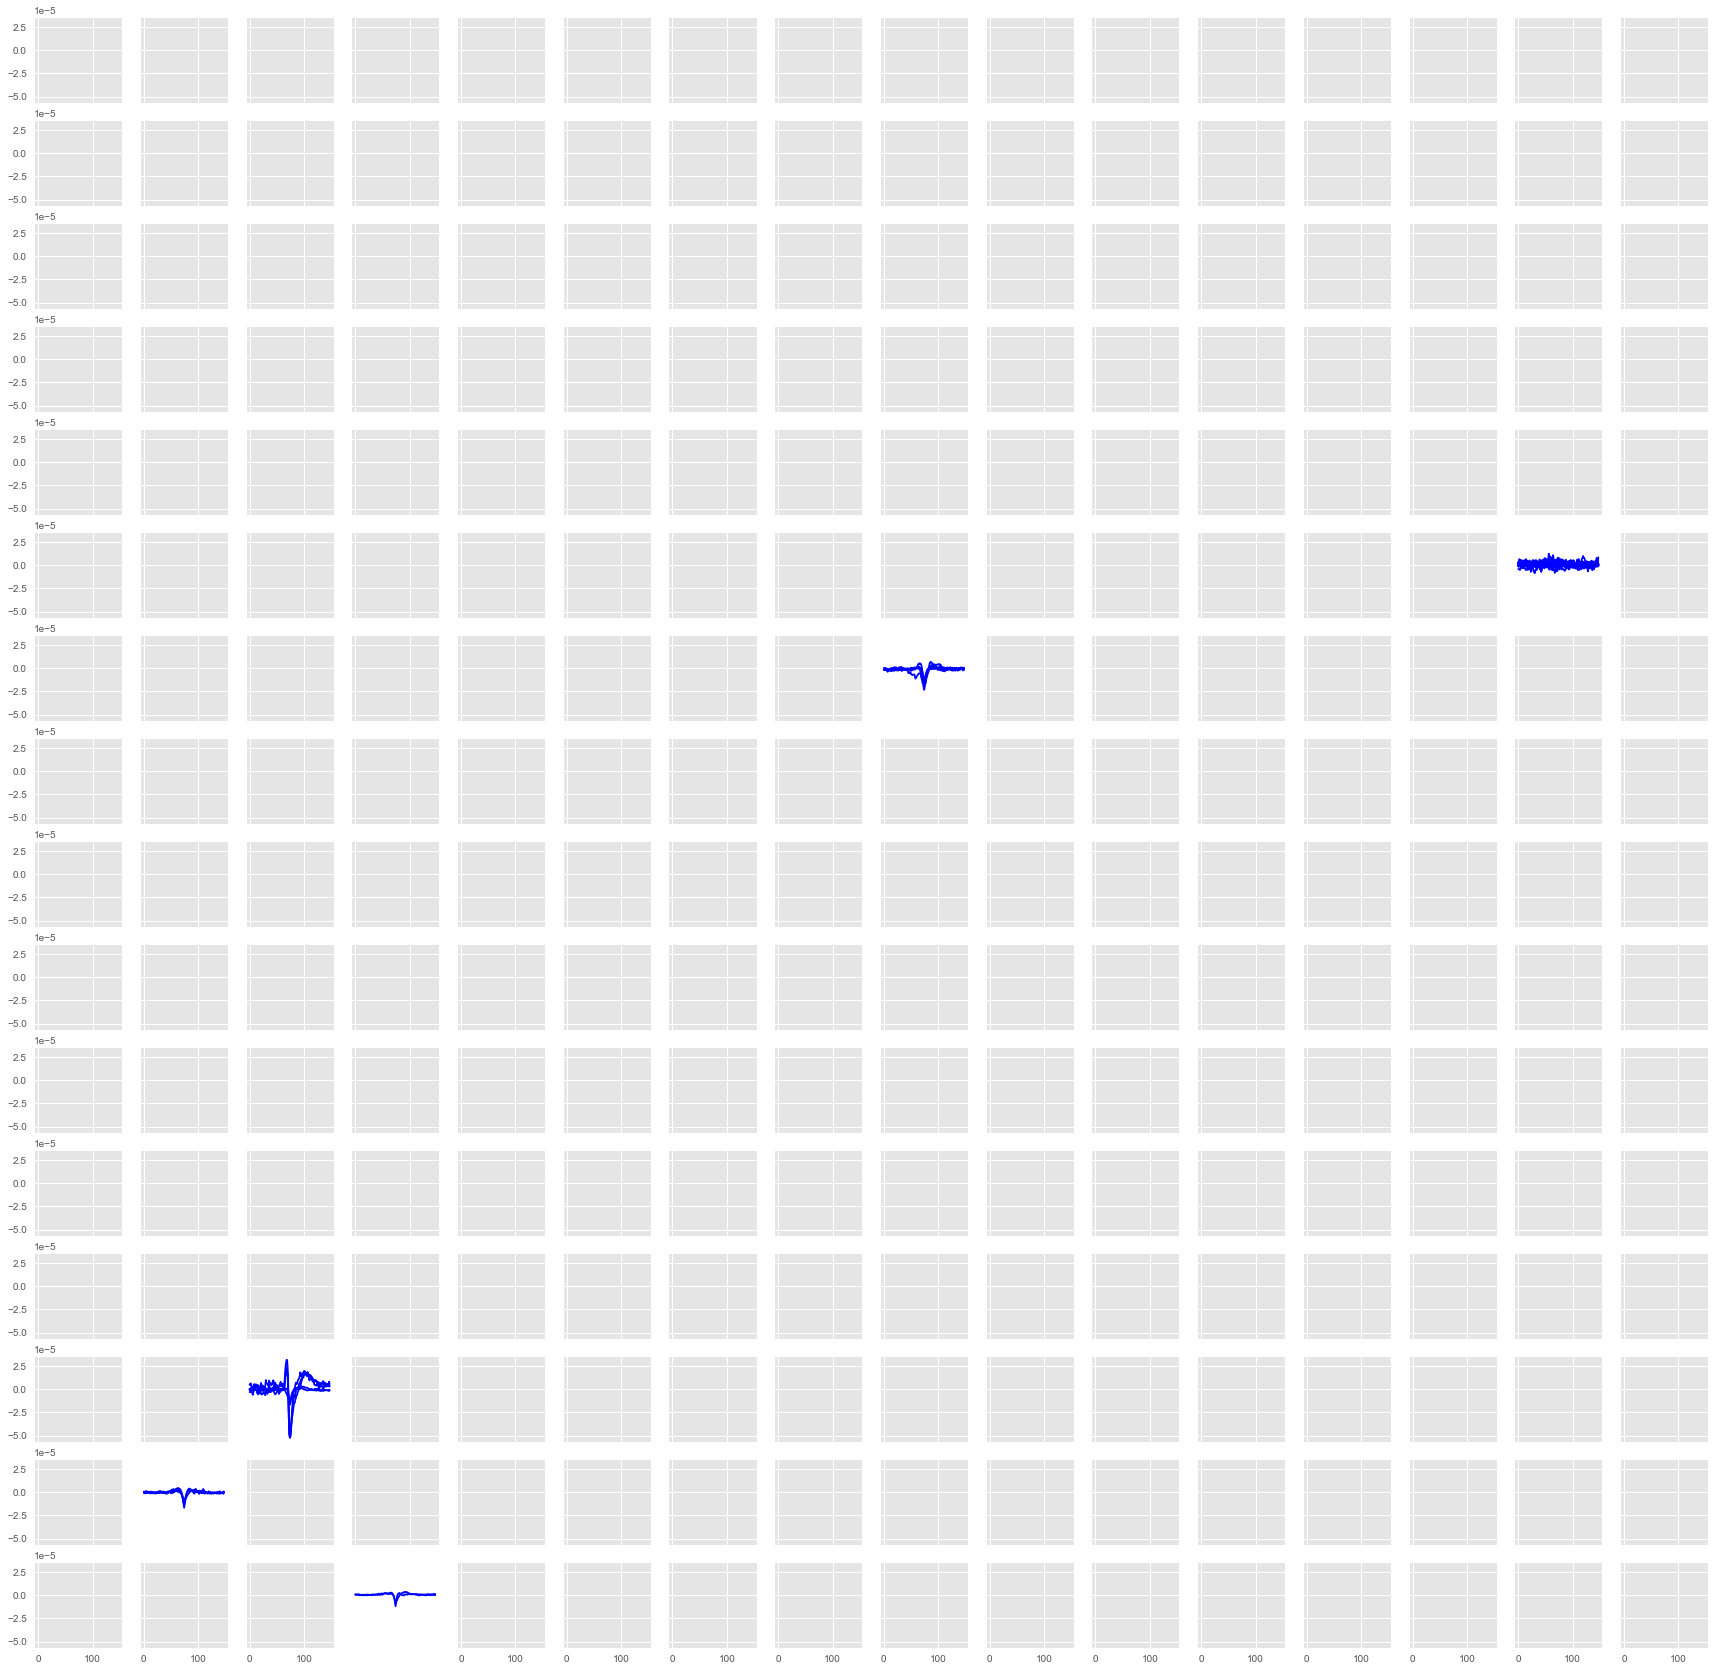

In [79]:
# plots stimmen noch nicht mit den eigentlichen channels überein
plt.style.use("seaborn")

fig, ax = plt.subplots(nrows=16, ncols=16, sharex=True, 
                       sharey=True,figsize=(30, 30))

#colors = iter(cm.jet(np.linspace(0, 1, len(unitlist_by_index))))
unique_labels = unitframe['channellabel'].unique()

for channel in unique_labels[:5]:
    # get the number of that channel (i.e, the max-channel)
    j=labeldic_invert[channel]
    print(channel)
    
    # gets the ax location for that channel m=letter, n=number
    m = label_loc_dic[channel][0]
    n = label_loc_dic[channel][1]
  
    unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index
    unitlist_by_channel = list(unitframe.loc[(unitframe['max_channel'])==j]['unit_ids'])
    print(unitlist_by_index)
    unitframe.loc[unitlist_by_index[0]]['channellabel']
    for i in unitlist_by_index:
        ax[m,n].plot(templates[i][j].T, color='b')
        ax[m,n].axis('off')

for key in label_loc_dic:
    m = label_loc_dic[channel][0]
    n = label_loc_dic[channel][1]
    ax[m,n].axis('off')
    ax[m,n].tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax[m,n].tick_params(axis = "y", which = "both", bottom = False, top = False)



# sw.plot_unit_waveforms(recording=recording_cache, sorting=sorting_SC, unit_ids=[0], color='b', max_channels=1,
#                        set_title=None, axis_equal=True, figure=fig, ax=ax[15,15])
    
#fig.show()

In [295]:
j=unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][:1]

In [300]:
j=labeldic_invert[channel]

In [301]:
j

30

In [274]:
j = int(unitframe.loc[(unitframe['channellabel']==channel)]['max_channel'][0])

In [275]:
j

0

In [73]:
unique_channels = unitframe['max_channel'].unique()
unique_labels = unitframe['channellabel'].unique()


In [74]:
# short function to create ax locations according to MCS MEA Layout

label_loc_dic = {}
channels = list(labeldic.values())

letters= []
for key in labeldic:
    letter = labeldic[key][:1]
    letters.append(letter)
letters = list(dict.fromkeys(letters))
letters.sort()

numbers = []
for key in labeldic:
    number = labeldic[key][1:]
    numbers.append(number)
numbers = list(dict.fromkeys(numbers))
numbers.sort()
    
for i in channels:
    letter = i[:1]
    number = i[1:]
    label_loc_dic[i] = [letters.index(letter), numbers.index(number)]

In [265]:
unitframe.loc[(unitframe['channellabel']=='R12')]['max_channel'][0]

0.0

In [276]:
unitlist_by_index=unitframe.loc[(unitframe['max_channel']==j)].index

In [281]:
unitlist_by_index[1]

1

In [84]:
spiketrains = sorted_dic['sec_0-300'].get_unit_spike_train(101)

In [23]:
completeframe

,unit_ids,max_channel,channellabel,n_spikes,firing_rate,layer,file,subrecording,recordingdate
0,0,0.0,R12,52.0,0.173333,layer2-3,aCSF_adult_15min_spont,sec_0-300,21.10.2019
1,1,10.0,R4,377.0,1.256667,layer2-3,aCSF_adult_15min_spont,sec_0-300,21.10.2019
2,10,30.0,O11,281.0,0.936667,layer2-3,aCSF_adult_15min_spont,sec_0-300,21.10.2019
3,100,61.0,I14,207.0,0.690000,layer5-6,aCSF_adult_15min_spont,sec_0-300,21.10.2019
4,101,61.0,I14,677.0,2.256667,layer5-6,aCSF_adult_15min_spont,sec_0-300,21.10.2019
...,...,...,...,...,...,...,...,...,...
743,95,41.0,L7,904.0,3.013333,layer4,aCSF_adult_15min_spont,sec_600-900,21.10.2019
744,96,41.0,L7,725.0,2.416667,layer4,aCSF_adult_15min_spont,sec_600-900,21.10.2019
745,97,41.0,L7,394.0,1.313333,layer4,aCSF_adult_15min_spont,sec_600-900,21.10.2019
746,98,73.0,K8,6.0,0.020000,layer5-6,aCSF_adult_15min_spont,sec_600-900,21.10.2019


In [89]:
spiketrains[-1]*40*1e-06

299.89376

In [46]:
sorted_dic['sec_600-900'].get_unit_spike_train(738)

array([  71740,   93679,  134948,  247494,  315749,  347810,  434513,
        498629,  519911,  651239,  693089,  804853,  806781,  919257,
        947150, 1017888, 1027941, 1128111, 1272067, 1284836, 1338074,
       1353054, 1409184, 1473250, 1565704, 1588098, 1652391, 1659005,
       1662722, 1670048, 1792140, 1800162, 1968482, 2187311, 2254198,
       2285973, 2313702, 2323522, 2343303, 2406492, 2409873, 2642175,
       2653758, 2675951, 2689263, 2699192, 2824576, 2866579, 2876474,
       2880031, 2973051, 3022124, 3113575, 3147144, 3173382, 3247290,
       3247777, 3278965, 3298743, 3340529, 3407218, 3495471, 3535905,
       3622510, 3622561, 3622694, 3686299, 3921646, 3968107, 4019723,
       4062498, 4079923, 4183682, 4284639, 4395067, 4501265, 4534757,
       4571146, 4704716, 4712765, 4727888, 4731820, 4777421, 4800731,
       4853714, 4861485, 4868642, 4871146, 4880282, 4946665, 4959993,
       4971934, 5029487, 5039707, 5081060, 5089773, 5117930, 5172033,
       5199427, 5214

In [47]:
unit_i = list(unitframe.loc[(unitframe['channellabel']=='M16')]['unit_ids'])

In [48]:
unit_i

[548, 738, 739]

In [54]:
dictkey = 'sec_600-900'
spikechannellist = []
spikedictionary_neuron = {}

In [55]:
for i in unit_i:
    spiketrains = sorted_dic[dictkey].get_unit_spike_train(i)
    spikechannellist.append(list(spiketrains))
    spikedictionary_neuron[i]=spiketrains

In [57]:
unit_ids = sorted_dic[dictkey].get_unit_ids()

In [56]:
spikedictionary_neuron

{548: array([   2264,    9276,   17830,   23839,   53753,   54837,   73866,
          74513,   75510,  108835,  124577,  125400,  131952,  138183,
         141797,  149471,  170044,  191822,  197223,  207024,  222318,
         252516,  257339,  257404,  280877,  285168,  314394,  320230,
         339314,  343896,  344369,  355559,  368941,  371911,  373258,
         375793,  376337,  394672,  437891,  439451,  456457,  460434,
         487621,  495327,  496633,  499613,  506934,  524928,  529616,
         535994,  536893,  557398,  574890,  577728,  597853,  624291,
         639596,  640077,  642027,  645368,  648256,  704585,  722978,
         725113,  770203,  802018,  805883,  816584,  835711,  837589,
         862735,  875015,  907471,  909748,  943530,  944748,  948769,
         965425,  969550,  974094,  983493,  997565, 1026216, 1040563,
        1041836, 1049652, 1059235, 1064379, 1077307, 1084622, 1099549,
        1106828, 1115098, 1148813, 1200680, 1201905, 1214551, 1214728,
 

In [207]:
# for single subrecordings
def spiketrains_to_spikedictionary_channel(sorting_dic, unitframe, dictkey):
    
    labels = unitframe['channellabel'].unique()
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    spikechannellist = []
    spikedictionary_channel = {}
    spikedictionary_neuron = {}
    spikedictionary_channel_neuron = {}
    sub_spikedictionary_channel_neuron ={}
    
    for label in labels:
        sub_spikedictionary_channel_neuron ={}
        spikechannellist = []
        unit_i = list(unitframe.loc[(unitframe['channellabel']==label)]['unit_ids'])
        for i in unit_i:
            spiketrains = sorted_dic[dictkey].get_unit_spike_train(i)
            spikechannellist.append(list(spiketrains))
            spikedictionary_neuron[i]=spiketrains
            sub_spikedictionary_channel_neuron[i]=spiketrains
        spikechannellist = sorted(list(itertools.chain.from_iterable(spikechannellist)))
        spikedictionary_channel[label]=spikechannellist
        spikedictionary_channel_neuron[label]=sub_spikedictionary_channel_neuron
        
    return spikedictionary_channel, spikedictionary_neuron, spikedictionary_channel_neuron
    
    

In [208]:
spiketrains = sorted_dic['sec_600-900'].get_unit_spike_train(10)

In [209]:
spiketrains

array([   1928,    9547,   13248, ..., 7470594, 7484644, 7499819],
      dtype=int64)

In [212]:
sd_c, sd_n, sd_cn = spiketrains_to_spikedictionary_channel(
    sorting_dic = sorted_dic,
    unitframe = unitframe,
    dictkey='sec_600-900')



In [213]:
# for complete dataframe
# def spiketrains_to_spikedictionary_channel(sorting_dic, unitframe):
    
    
# #     dictkeys = unitframe['subrecording'].unique()
# #     for i in dictkey:
# #         dictkey = i
    
#     labels = unitframe['channellabel'].unique()
#     unit_ids = sorted_dic[dictkey].get_unit_ids()
#     spikechannellist = []
#     spikedictionary_channel = {}
#     spikedictionary_neuron = {}
#     spikedictionary_channel_neuron = {}
#     sub_spikedictionary_channel_neuron ={}

#     for label in labels:
#         sub_spikedictionary_channel_neuron ={}
#         spikechannellist = []
#         unit_i = list(unitframe.loc[(unitframe['channellabel']==label)]['unit_ids'])
#         for i in unit_i:
#             spiketrains = sorted_dic[dictkey].get_unit_spike_train(i)
#             spikechannellist.append(list(spiketrains))
#             spikedictionary_neuron[i]=spiketrains
#             sub_spikedictionary_channel_neuron[i]=spiketrains
#         spikedictionary_channel[label]=spikechannellist
#         spikedictionary_channel_neuron[label]=sub_spikedictionary_channel_neuron

#     return spikedictionary_channel, spikedictionary_neuron, spikedictionary_channel_neuron

In [214]:
len(sd_c)

247

In [75]:
# load a thershold detected spikedictionary
dictionary_direction = r'D:\Files_Reutlingen_Jenny\main_191021extra\191021_extra_output'
os.chdir(dictionary_direction)

file = glob.glob('*%s*crossings*.npy' %filebase)
        


In [76]:
file

['aCSF_adult_15min_spont.h5_crossings_dict.npy']

In [93]:
sd_threshold = np.load(file[0], allow_pickle= True).item()

In [95]:
dictkey

'sec_600-900'

In [215]:
# compare two dictionaries

def compare_threshold_vs_spikesorting(sd_c, sd_threshold, dictkey):
    timerange = dictkey.split('_')[1]
    t_start = int(timerange.split('-')[0])
    t_stop = int(timerange.split('-')[1])

    # dictionary of ratios that contains (number threshold)/(number spikesorting)
    spikeratio_dic = {}

    for key in sd_c:
        if type(key)==str:
            thresholdlist = []
            n_spikesorting = len(sd_c[key])

            threshold_in_seconds = sd_threshold[key]*40*1e-6 

            for i in threshold_in_seconds:
                if (i > t_start) and (i < t_stop):
                    thresholdlist.append(i)
            n_threshold = len(thresholdlist)

        spikeratio_dic[key]=math.log1p(n_threshold/n_spikesorting)
        
    return spikeratio_dic

In [201]:
spikeratio_dic = compare_threshold_vs_spikesorting(sd_c, sd_threshold, 'sec_600-900')

In [216]:
raster_data_ss = sd_c['G2']
raster_data_th = sd_threshold['G2']

In [217]:
raster_data_th_cut = []
t_start, t_stop = 600, 900
for i in raster_data_th:
    if (i > t_start) and (i < t_stop):
        raster_data_th_cut.append(i)

In [179]:
sd_c['G2']

[[18256,
  19452,
  72112,
  124613,
  124632,
  124786,
  158761,
  205975,
  206238,
  235276,
  236272,
  282121,
  319367,
  319508,
  319996,
  320227,
  320465,
  374289,
  401354,
  402040,
  402804,
  449668,
  449753,
  450519,
  500553,
  528152,
  563530,
  564337,
  598672,
  598898,
  650527,
  650542,
  691915,
  725761,
  726381,
  760290,
  760492,
  804645,
  805073,
  805384,
  874942,
  875071,
  875310,
  947255,
  947763,
  970588,
  970697,
  1061808,
  1061909,
  1099639,
  1099861,
  1100185,
  1100900,
  1124436,
  1124492,
  1150729,
  1244403,
  1287410,
  1287571,
  1316607,
  1317737,
  1368841,
  1369117,
  1369230,
  1369780,
  1443250,
  1471012,
  1471268,
  1471880,
  1498000,
  1498105,
  1498469,
  1541598,
  1543093,
  1575139,
  1604491,
  1605958,
  1630665,
  1631280,
  1667543,
  1668953,
  1695714,
  1696126,
  1696313,
  1731466,
  1789343,
  1790103,
  1790342,
  1790402,
  1833213,
  1833285,
  1864766,
  1864903,
  1865268,
  1865689,
  190

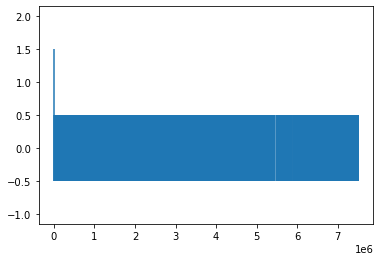

In [218]:
fig, ax = plt.eventplot([raster_data_ss, raster_data_th_cut])

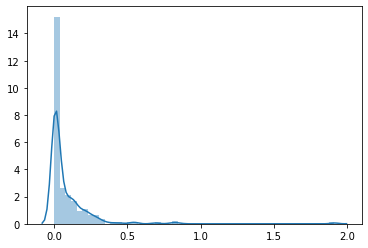

In [202]:
sns.distplot(np.asarray((list(spikeratio_dic.values()))))


In [110]:
for i in threshold_in_seconds:
    if (i > t_start) and (i < t_stop):
        n_threshold.append(i)

In [195]:
import math

In [189]:
spikeratio_dic

{'R12': 0.0971937029431896,
 'O11': 0.03821102909248806,
 'I14': 0.7386519944979367,
 'R10': 0.0023710729104919974,
 'P1': 0.011060507482108002,
 'G2': 0.2511192511192511,
 'F8': 0.2800863464651916,
 'P10': 0.004381161007667032,
 'P2': 0.002904162633107454,
 'G1': 0.20681021532298446,
 'B6': 0.004125412541254125,
 'B12': 0.0036258158085569255,
 'H16': 0.0048543689320388345,
 'D7': 0.04372355430183357,
 'F10': 0.3226795096322242,
 'D14': 0.0025906735751295338,
 'D2': 0.47368421052631576,
 'D3': 0.23419864559819414,
 'F9': 0.08250825082508251,
 'G9': 0.035600425079702444,
 'K7': 0.07092980521866961,
 'O15': 0.004127358490566038,
 'G8': 0.0038948393378773127,
 'N15': 0.0027726432532347504,
 'D1': 0.00808080808080808,
 'O10': 0.008579599618684462,
 'R2': 0.0014958863126402393,
 'F2': 0.3241616509028375,
 'G4': 0.3185763888888889,
 'F3': 0.31135531135531136,
 'M9': 0.015137180700094607,
 'N4': 0.008985879332477536,
 'G3': 0.056146088852548376,
 'K10': 1.2387687188019967,
 'O8': 0.0315315315